In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F


seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

d_in = 5
d_out = 5
train_size = 100
test_size = 100
w = 100

def init(model, alpha):
    state_dict = model.state_dict()
    modules = ["l1.weight", "l1.bias", "l2.weight", "l2.bias", "l3.weight", "l3.bias"]
    for module in modules:
        state_dict[module] = state_dict[module] * alpha
    model.load_state_dict(state_dict)
    
class Net(nn.Module):

    def __init__(self, w=w):
        super(Net, self).__init__()
        self.l1 = nn.Linear(d_in, w)
        self.l2 = nn.Linear(w, w)
        self.l3 = nn.Linear(w,d_out)

    def forward(self, x):
        f = torch.nn.Tanh()
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        return self.x3
    
teacher = Net()
alpha = 1.0
init(teacher, alpha=alpha)
inputs_train = torch.tensor(torch.normal(0,1,size=(train_size, d_in)), dtype=torch.float, requires_grad=True)
labels_train = torch.tensor(teacher(inputs_train), dtype=torch.float, requires_grad=True)

inputs_test = torch.normal(0,1,size=(test_size, d_in))
labels_test = teacher(inputs_test)

/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_25389/2325880044.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_train = torch.tensor(torch.normal(0,1,size=(train_size, d_in)), dtype=torch.float, requires_grad=True)
/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_25389/2325880044.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(teacher(inputs_train), dtype=torch.float, requires_grad=True)


In [3]:
def L2(model):
    params = list(model.parameters())
    l2 = 0
    for i in range(6):
        if i == 0:
            params_flatten = params[i].reshape(-1,)
        params_flatten = torch.cat([params_flatten, params[i].reshape(-1,)])
    l2 = torch.sum(params_flatten**2)
    return params_flatten, l2


    
def init2(model, alpha):
    model.l1.weight.data = model.l1.weight * alpha
    model.l1.bias.data = model.l1.bias * alpha
    model.l2.weight.data = model.l2.weight * alpha
    model.l2.bias.data = model.l2.bias * alpha
    model.l3.weight.data = model.l3.weight * alpha
    model.l3.bias.data = model.l3.bias * alpha

    
def grad(model):
    grads = list(student.parameters())
    for i in range(6):
        if i == 0:
            grad = grads[0].reshape(-1,)
        else:
            grad = torch.cat([grad, grads[i].reshape(-1,)])
    return grad
    

In [4]:
alpha = 2.0


print("---------alpha={}---------".format(alpha))
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
student = Net()

init(student, alpha=alpha)
_, scale = L2(student)

epochs = 100000
log = 200
wd = 0.05

optimizer = torch.optim.AdamW(student.parameters(), lr=3e-4, weight_decay = wd)

losses_train = []
losses_test = []
accs_train = []
accs_test = []

l2s = []
threshold = 0.001

for epoch in range(epochs):  # loop over the dataset multiple times

    optimizer.zero_grad()

    outputs_train = student(inputs_train)
    loss_train_vec = torch.mean((outputs_train-labels_train)**2, dim=1)
    loss_train = torch.mean(loss_train_vec)
    train_acc = torch.sum(loss_train_vec < threshold)/train_size
    
    outputs_test = student(inputs_test)
    loss_test_vec = torch.mean((outputs_test-labels_test)**2, dim=1)
    loss_test = torch.mean(loss_test_vec)
    test_acc = torch.sum(loss_test_vec < threshold)/test_size
    
    params, l2 = L2(student)
    #init2(student, alpha=torch.sqrt(scale/l2))
    #params, l2 = L2(student)

    loss_train.backward()

    optimizer.step()

    if epoch % log == 0:
        print("epoch: %d  | Train loss: %.6f |  Test loss: %.6f | train_acc: %.2f | test_acc: %.2f | l2: %.6f"%(epoch, loss_train.detach().numpy(), loss_test.detach().numpy(), train_acc.detach().numpy(), test_acc.detach().numpy(), l2.detach().numpy()))

    losses_train.append(loss_train.detach().numpy())
    losses_test.append(loss_test.detach().numpy())
    l2s.append(l2.detach().numpy())
    accs_train.append(train_acc.detach().numpy())
    accs_test.append(test_acc.detach().numpy())


---------alpha=2.0---------
epoch: 0  | Train loss: 0.359951 |  Test loss: 0.351991 | train_acc: 0.00 | test_acc: 0.00 | l2: 429.586884
epoch: 200  | Train loss: 0.002719 |  Test loss: 0.016901 | train_acc: 0.14 | test_acc: 0.04 | l2: 423.566223
epoch: 400  | Train loss: 0.000940 |  Test loss: 0.012941 | train_acc: 0.64 | test_acc: 0.07 | l2: 419.681122
epoch: 600  | Train loss: 0.000452 |  Test loss: 0.011120 | train_acc: 0.91 | test_acc: 0.10 | l2: 416.279297
epoch: 800  | Train loss: 0.000249 |  Test loss: 0.010040 | train_acc: 0.99 | test_acc: 0.11 | l2: 413.170135
epoch: 1000  | Train loss: 0.000151 |  Test loss: 0.009309 | train_acc: 0.99 | test_acc: 0.13 | l2: 410.261963
epoch: 1200  | Train loss: 0.000097 |  Test loss: 0.008765 | train_acc: 1.00 | test_acc: 0.16 | l2: 407.503845
epoch: 1400  | Train loss: 0.000065 |  Test loss: 0.008334 | train_acc: 1.00 | test_acc: 0.16 | l2: 404.859192
epoch: 1600  | Train loss: 0.000044 |  Test loss: 0.007978 | train_acc: 1.00 | test_acc: 0.

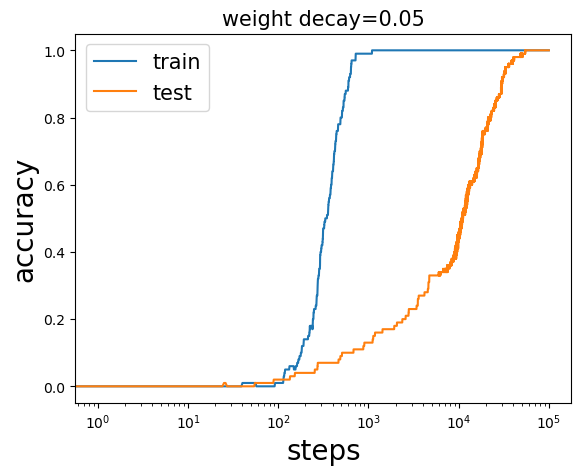

In [5]:
plt.plot(np.arange(epochs), accs_train)
plt.plot(np.arange(epochs), accs_test)
plt.xlabel("steps", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.legend(["train", "test"], fontsize=15)
plt.title("weight decay=0.05", fontsize=15)
plt.xscale('log')